# Machine Learning et données cryptées - correction

Comment faire du machine learning avec des données cryptées ? Ce notebook propose d'en montrer un principe exposés [CryptoNets: Applying Neural Networks to Encrypted Data with High Throughput and Accuracy](http://proceedings.mlr.press/v48/gilad-bachrach16.pdf). Correction.

In [ ]:
%matplotlib inline

In [ ]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

**Principe**

Voir l'énoncé.

## Exercice 1 : écrire deux fonctions de cryptage, décryptage

Il faut bien choisir $n$, $a$ pour implémenter la fonction de cryptage :
$\varepsilon:\mathbb{N} \rightarrow \mathbb{Z}/n\mathbb{Z}$ et $\varepsilon(x) = (x * a) \mod n$. On vérifie ensuite qu'elle conserve l'addition.

In [ ]:
def compose(x, a, n):
    return (a * x) % n

def crypt(x):
    return compose(x, 577, 10000)

crypt(5), crypt(6)

(2885, 3462)

In [ ]:
crypt(5+6), (crypt(5) + crypt(6)) % 10000

(6347, 6347)

In [ ]:
crypt(6-5), (crypt(6) - crypt(5)) % 10000

(577, 577)

In [ ]:
crypt(5-6), (crypt(5) - crypt(6)) % 10000

(9423, 9423)

Si $a=47$, on cherche $a',k$ tel que $aa' - nk=1$.

In [ ]:
n = 10000
for k in range(2, n):
    if (577*k) % n == 1:
        ap = k
        break
ap

2513

In [ ]:
def decrypt(x):
    return compose(x, 2513, 10000)

decrypt(crypt(5)), decrypt(crypt(6))

(5, 6)

In [ ]:
decrypt(crypt(5)*67), decrypt(crypt(5*67))

(335, 335)

## Exercice 2 : Entraîner une régression linéaire

In [ ]:
from sklearn.datasets import load_diabetes
data = load_diabetes()

In [ ]:
X = data.data
Y = data.target

In [ ]:
from sklearn.linear_model import LinearRegression
clr = LinearRegression()
clr.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [ ]:
clr.predict(X[:1]), Y[0]

(array([ 206.11706979]), 151.0)

In [ ]:
r2_score(Y, clr.predict(X))

0.51774942541329338

On considère seulement la fonction de décision brute car c'est une fonction qui peut-être calculée à partir d'additions et de multiplications. Pour la suite, nous aurons besoin d'un modèle qui fonctionne sur des variables normalisées avec [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html). On supprime également le biais pour le remplacer par une colonne constante.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy
X_norm = numpy.hstack([MinMaxScaler((0, 100)).fit_transform(X), 
                       numpy.ones((X.shape[0], 1))])
Y_norm = MinMaxScaler((0, 100)).fit_transform(Y.reshape(len(Y), 1)).ravel()

In [ ]:
Y_norm.min(), Y_norm.max()

(0.0, 100.0)

In [ ]:
clr_norm = LinearRegression(fit_intercept=False)
clr_norm.fit(X_norm, Y_norm)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [ ]:
clr_norm.predict(X_norm[:1]), Y_norm[0]

(array([ 56.42276317]), 39.252336448598129)

In [ ]:
from sklearn.metrics import r2_score
r2_score(Y_norm, clr_norm.predict(X_norm))

0.51774942541329338

## Exercice 3 : réécrire la fonction de prédiction pour une régression linéaire

La fonction est un produit scalaire.

In [ ]:
def decision_linreg(xs, coef, bias):
    s = bias
    xs = xs.copy().ravel()
    coef = coef.copy().ravel()
    if xs.shape != coef.shape:
        raise ValueError("Not the same dimension {0}!={1}".format(xs.shape, coef.shape))
    for x, c in zip(xs, coef):
        s += c * x
    return s

In [ ]:
list(X[0])[:5]

[0.038075906433424102,
 0.050680118739818703,
 0.061696206518688498,
 0.021872354994955798,
 -0.044223498424446402]

In [ ]:
clr.predict(X[:1]), decision_linreg(X[:1], clr.coef_, clr.intercept_)

(array([ 206.11706979]), 206.1170697870923)

In [ ]:
clr_norm.predict(X_norm[:1]), decision_linreg(X_norm[:1], clr_norm.coef_, clr_norm.intercept_)

(array([ 56.42276317]), 56.422763173548944)

## Exercice 4 : assembler le tout

Prendre une observation, crypter, prédire, décrypter, comparer avec la version non cryptée. Il faudra sans doute un peu ruser car la fonction de cryptage s'applique à des entiers et le modèle de prédiction à des réels. On multiplie par 10000 les variables. Comme le cryptage que nous avons choisi ne conserve que l'addition, nous garderons les modèles en clair.

In [ ]:
coef_int = [int(i) for i in clr_norm.coef_ * 100]
coef_int

[0, -7, 42, 24, -69, 46, 8, 14, 60, 5, -843]

In [ ]:
inter_int = int(clr_norm.intercept_ * 10000)
inter_int

0

In [ ]:
import numpy


def decision_linreg_int(xs, coef):
    s = 0
    for x, c in zip(xs, coef):
        s += c * x
    return s % 10000

def decision_crypt_decrypt_linreg(xs, coef_int):
    # On crypte les entrées
    int_xs = [int(x) for x in xs.ravel()]
    crypt_xs = [crypt(i) for i in int_xs]
    # On applique la prédiction.
    pred = decision_linreg_int(crypt_xs, coef_int)
    # On décrypte.
    dec = decrypt(pred % 10000)
    return dec / 100

(decision_linreg(X_norm[:1], clr_norm.coef_, clr_norm.intercept_), 
 decision_crypt_decrypt_linreg(X_norm[0], coef_int))

(56.422763173548944, 54.65)

0 56.4227631735 54.65
1 13.4181768255 11.59
2 47.3159066512 45.73
3 44.2112042336 42.02
4 32.2304805013 30.26


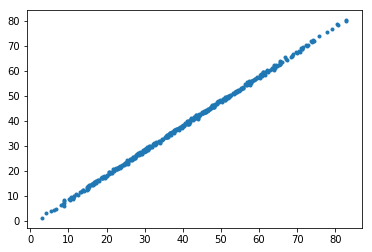

In [ ]:
p1s = []
p2s = []
for i in range(0, X_norm.shape[0]):
    p1 = decision_linreg(X_norm[i:i+1], clr_norm.coef_, clr_norm.intercept_)
    p2 = decision_crypt_decrypt_linreg(X_norm[i], coef_int)
    if i < 5:
        print(i, p1, p2)
    p1s.append(p1)
    p2s.append(p2)

import matplotlib.pyplot as plt
plt.plot(p1s, p2s, '.')

**Notes**

Les coefficients sont en clair mais les données sont cryptées. Pour crypter les coefficients du modèle, il faudrait pouvoir s'assurer que l'addition et la multiplication sont stables après le cryptage. Cela nécessite un cryptage différent comme [Fully Homomorphic Encryption over the Integers](https://eprint.iacr.org/2009/616.pdf). Les entiers cryptés sont dans l'intervalle [0, 10000], cela veut dire qu'il est préférable de crypter des entiers dans un intervalle équivalent sous peine de ne pouvoir décrypter avec certitude. Ceci implique que l'algorithme fasse des calculs qui restent dans cet intervalle. C'est pourquoi les entrées et les sorties prennent leur valeur dans l'intervalle [0, 100] afin que le produit *coefficient x entrée* reste dans l'intervalle considéré.

## Questions

Le cryptage choisi est moins efficace qu'un cryptage RSA qui conserve la multiplication. Il faudrait transformer l'écriture du modèle pour utiliser des multiplications plutôt que des additions. On peut entraîner un modèle sur des données cryptées si on peut reproduire l'addition et la multiplication avec les nombres cryptés. Une option est le cryptage : [Fully Homomorphic Encryption over the Integers](https://eprint.iacr.org/2009/616.pdf). Cela implique qu'on peut approcher toute fonction par un polynôme (voir [développement limité](https://fr.wikipedia.org/wiki/D%C3%A9veloppement_limit%C3%A9)). Le gradient d'un polynôme est un polynôme également. Il est possible de calculer la norme du gradient crypté mais pas de la comparer à une autre valeur cryptées.

De ce fait les arbres de décision se prêtent mal à ce type d'apprentissage puisque chaque noeud de l'arbre consiste à comparer deux valeurs. Cependant, on peut s'en sortir en imposant à l'algorithme d'apprentissage d'un arbre de décision de ne s'appuyer sur des égalités. Cela nécessite plus de coefficients et la discrétisation des variables continues. Il reste une dernière chose à vérifier. Chaque noeud d'un arbre de décision est déterminé en maximisant une quantité. Comment trouver le maximum dans un ensemble de données cryptées qu'on ne peut comparer ? On utilise une propriété des normes :

$$\lim_{d \rightarrow \infty} (x^d + y^d)^{1/d} = \max(x, y)$$

Il existe d'autres options : [Machine Learning Classification over Encrypted Data](https://eprint.iacr.org/2014/331.pdf).